## 모듈 불러오기

In [1]:
import time
import copy
import random
import glob
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## CUDA 코어 테스트 & 할당

In [2]:
print(torch.cuda.get_device_name())
print(torch.__version__)
print(torch.version.cuda)
x = torch.randn(1).cuda()
print(x)

NVIDIA GeForce GTX 1650
2.1.1
11.8
tensor([-1.2726], device='cuda:0')


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 하이퍼 파라미터 (Hyper Parameter)
- 필요에 따라 수정(추가 및 삭제 가능)
- mean, standard deviation은 수정 비추천
- seed를 고정값으로 사용하면 커널을 초기화하고 다시 Run을해도 고정된 학습결과가 나타남. 테스트나 확인해야할 사항이 있을 때 seed 임의조절 가능. 랜덤하게 사용하고 싶다면 주석처리된 코드 이용.

In [4]:
params = {
  'img_size':224,
  'epoch': 10,
  'learning_rate': 0.05,
  'batch_size': 32,
  'seed': random.randrange(1, 10000000),
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'workers': 6, # 본인 cpu 코어의 절반 정도
  'num_show_img': 5, # 데이터 확인 시 보여줄 데이터 개수
  'momentum': 0.9,
  'weight_decay': 1e-4,
}

## Efficientnet B0 모델 & 데이터 불러오기

In [5]:
# efficientnet-b0을 from_pretrained 메소드로 기 학습된 모델을 가져온다. (전이학습)
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=5)

random.seed(params['seed']) # 코드 테스트용, 랜덤 시드 고정
torch.manual_seed(params['seed'])

data_path = './S63_DATA1-001'
industrial_dataset = datasets.ImageFolder(
                      data_path,
                      transforms.Compose([
                        transforms.Resize((224, 224)), # efficientnet-b0 이미지 규격에 맞춤
                        transforms.ToTensor(), # 텐서화
                        transforms.Normalize(mean=params['mean'], std=params['std'])
                      ])) # 연구진들이 가장 최적화된 정규화 값을 찾음. 안정된 학습을 위한 데이터 정규화.

224
Loaded pretrained weights for efficientnet-b0


## 데이터를 Train:Valid:Test=8:1:1로 나누기

In [6]:
# train : valid : test = 8 : 1 : 1
train_idx, tmp_idx = train_test_split(list(range(len(industrial_dataset))), test_size=0.2, random_state=params['seed'])
data_sets = {}
data_sets['train'] = Subset(industrial_dataset, train_idx)
tmp_dataset = Subset(industrial_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=params['seed'])
data_sets['valid'] = Subset(tmp_dataset, val_idx)
data_sets['test'] = Subset(tmp_dataset, test_idx)

## 데이터 로더 정의 & 사이즈 확인

In [7]:
# data loader
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(data_sets['train'],
                                  batch_size=params['batch_size'],
                                  shuffle=True,
                                  num_workers=params['workers'])
dataloaders['valid'] = DataLoader(data_sets['valid'],
                                  batch_size=params['batch_size'],
                                  shuffle=False,
                                  num_workers=params['workers'])
dataloaders['test'] = DataLoader(data_sets['test'],
                                  batch_size=params['batch_size'],
                                  shuffle=False,
                                  num_workers=params['workers'])
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (params['batch_size'], batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 32,  tvt : 750 / 94 / 94


## GradCam을 통한 모델 세부 분석

- Requirement
``` shell
pip install grad-cam
```

In [8]:
pt_file_name = '231207_01.pt'

In [9]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [10]:
# 학습이 GPU 상태에서 진행되었는지 CPU 상태에서 진행되었는지 상관 없이 활용할 수 있도록 map_location 매개 변수 통해 장치(device)를 적용합니다.
model_dict = torch.load(pt_file_name, map_location=device)
model_name = 'efficientnet-b0'
trained_model = EfficientNet.from_pretrained(model_name, num_classes=5)
trained_model.load_state_dict(model_dict)
trained_model = trained_model.to(device)

# CUDA 확인
print(f"CUDA:{next(trained_model.parameters()).is_cuda}")

print(trained_model)
# Grad-Cam은 모델의 순전파 역전파과정 모두 이용함. 모델의 레이어 하나를 가져와야하기 때문에 레이어 확인 필수

Loaded pretrained weights for efficientnet-b0
CUDA:True
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32

In [11]:
def imgDecode(input):
  """Img show for Tensor."""
  input = input.numpy().transpose((1,2,0))
  input = params['std'] * input + params['mean']
  input = np.clip(input, 0, 1)
  return input

In [12]:
target_layer = [trained_model._blocks[-1]] # efficientNet-B0의 마지막 Convolution Layer
input_tensor, classes = next(iter(dataloaders['test']))

cam = GradCAM(model=trained_model, target_layers=target_layer, use_cuda=True)

targets = [ClassifierOutputTarget(classes)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

visualizations = []
for i in range(len(input_tensor)):
 visualizations.append(show_cam_on_image(imgDecode(input_tensor[i]), grayscale_cam[i, :], use_rgb=True))

tensor([11.8412, -3.9350, -4.1475, -1.2746, -1.2746, -1.7309, 11.8412, -1.7309,
        11.8412, -1.2746, -1.2746, 11.8412, -4.1475, -4.1475, -3.9350, -4.1475,
        -4.1475, -1.2746, -1.7309, -1.2746, -4.1475, -3.9350, -3.9350, 11.8412,
        11.8412, -1.2746, 11.8412, -1.2746, -4.1475, -1.2746, 11.8412, -4.1475],
       device='cuda:0', grad_fn=<IndexBackward0>)


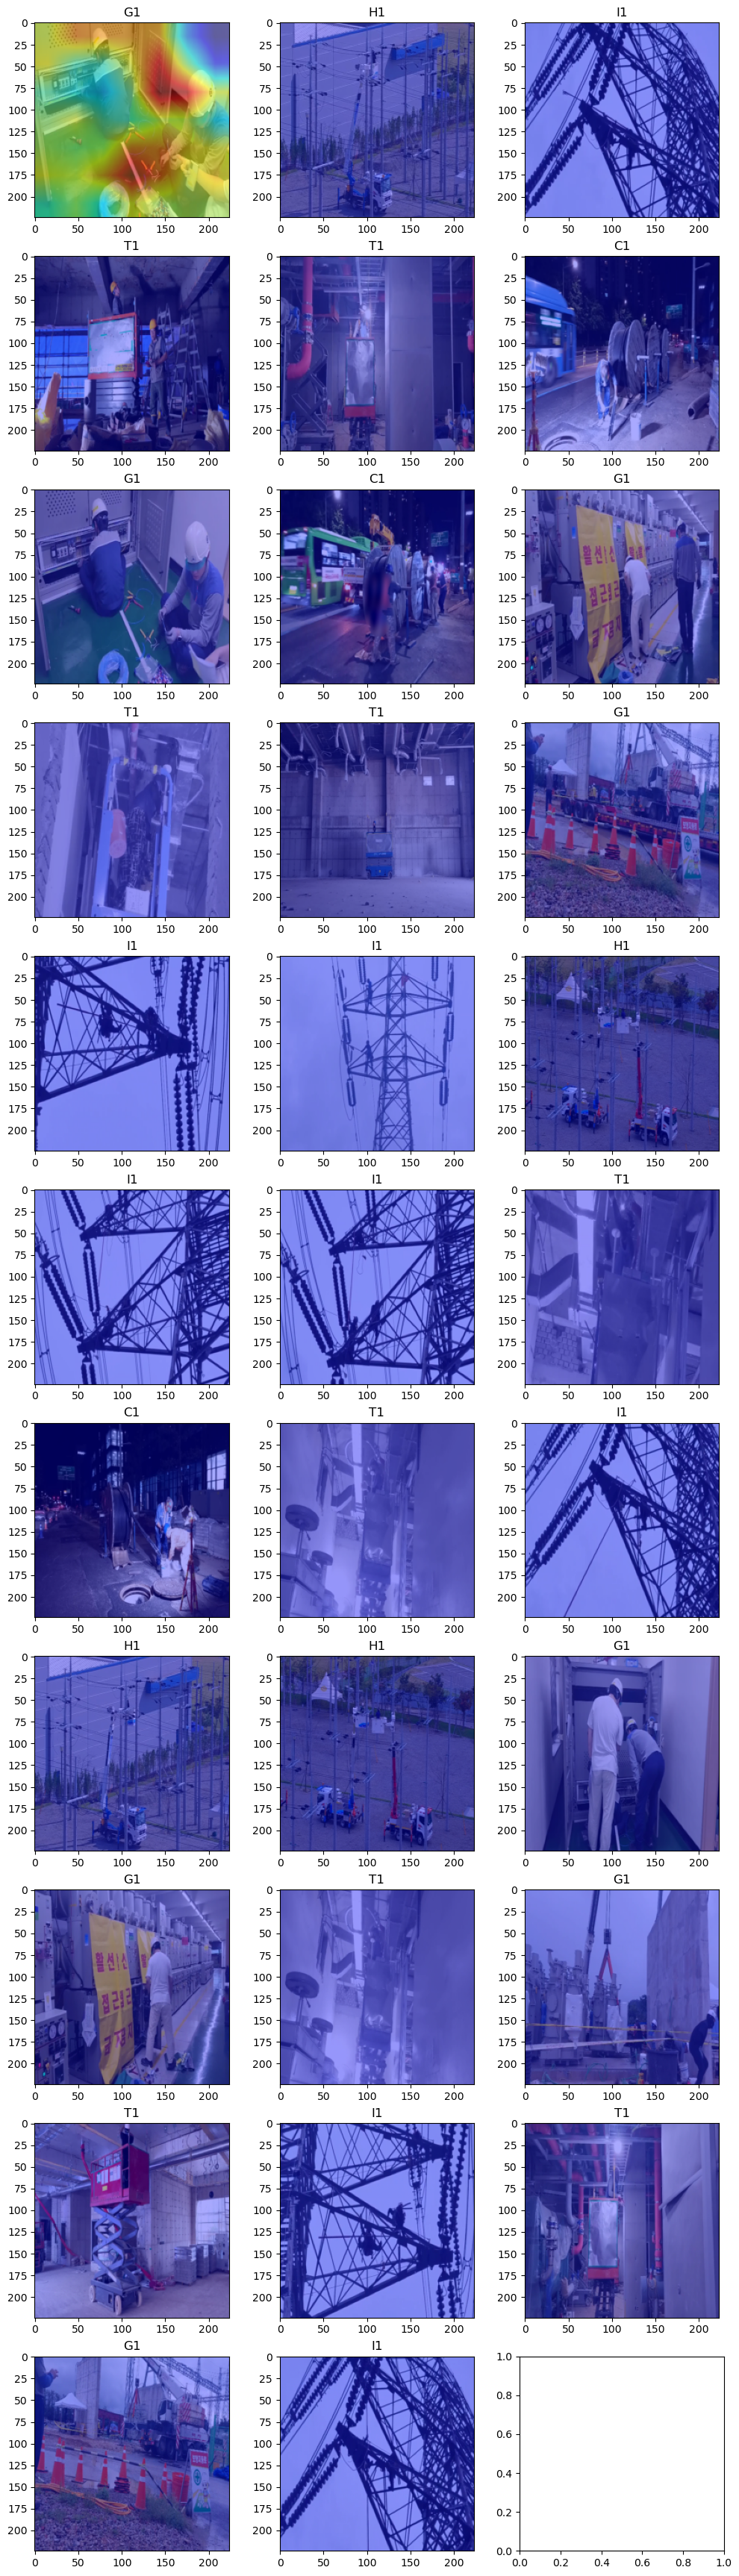

In [13]:
class_names = {
  "0": "C1",
  "1": "G1",
  "2": "H1",
  "3": "I1",
  "4": "T1"
}

cols = 3
rows = len(visualizations) // cols
if len(visualizations) % cols:
  rows += 1

fig, ax = plt.subplots(rows, cols, figsize=(cols*4, rows*4))

for index, img in enumerate(visualizations):
  ax[index // cols, index % cols].imshow(img)
  ax[index // cols, index % cols].set_title(class_names[str(int(classes[index]))])